In [1]:
# Importing Important Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# Loading the Dataset

df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Observation:

The dataset contains customer demographic, service, and billing details.

The target variable Churn indicates whether the customer left the service.

In [29]:
# Understanding the Data:

df.shape

(7032, 31)

Observation:

The dataset contains more than 7,000 rows and 21 columns, which is suitable for machine learning modeling.

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Observation:

Most columns are categorical.

TotalCharges is stored as an object and requires conversion.

In [5]:
df.describe()


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df['Churn'].value_counts(normalize=True)


,proportion
Churn,
No,0.73463
Yes,0.26537


Observation:

The dataset is imbalanced, with ~27% churned customers.

Accuracy alone is not sufficient; ROC-AUC and recall are important.

In [8]:
# Data Cleaning
#Convert TotalCharges to numeric

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


Observation:

Missing values are present only in TotalCharges.

In [9]:
df.isnull().sum()


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [10]:
df.dropna(inplace=True)


Observation:

Rows with invalid TotalCharges values have been removed.

In [11]:
# Drop unnecessary column

df.drop('customerID', axis=1, inplace=True)



In [12]:
# Exploratory Data Analysis (EDA)

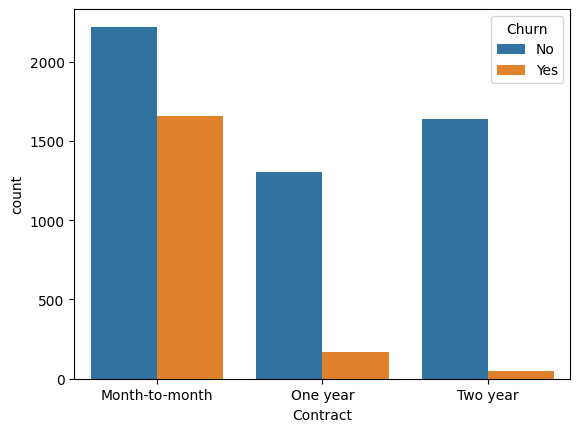

In [13]:
#Churn vs Contract

sns.countplot(x='Contract', hue='Churn', data=df)
plt.show()


Insight:

Customers with month-to-month contracts churn significantly more.

Long-term contracts improve customer retention.

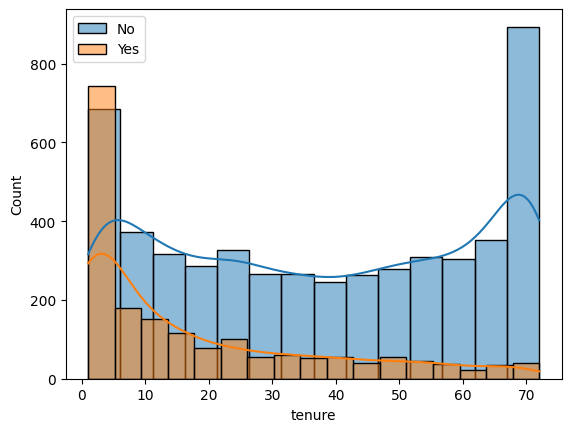

In [14]:
# Churn vs Tenure
sns.histplot(df[df['Churn']=='No']['tenure'], label='No', kde=True)
sns.histplot(df[df['Churn']=='Yes']['tenure'], label='Yes', kde=True)
plt.legend()
plt.show()


Insight:

Customers with shorter tenure are more likely to churn.

Long-term customers show strong loyalty.

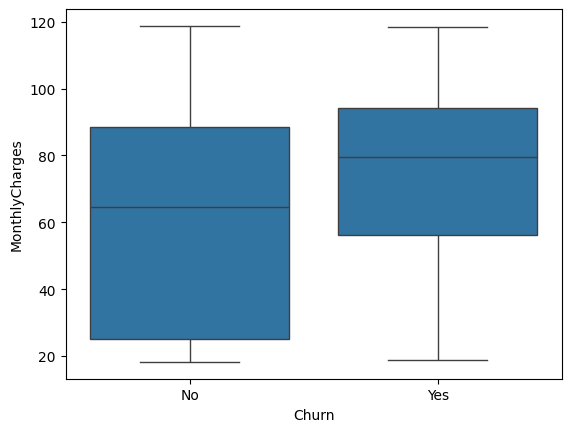

In [15]:
# Churn vs Monthly Charges
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.show()

Insight:

Customers who churn generally have higher monthly charges.

Pricing sensitivity plays an important role in churn.

In [16]:
# Feature Engineering
# Convert target variable
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

In [17]:
# Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

Observation:

Categorical variables are converted into numerical format for modeling.

In [18]:
#Feature Scaling
scaler = StandardScaler()

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [19]:
# Train-Test Split
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
# Model Building
# Logistic Regression (Baseline)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [22]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [23]:
# XGBoost (Best Performer)
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



Insight:

XGBoost delivers the best balance of precision and recall.

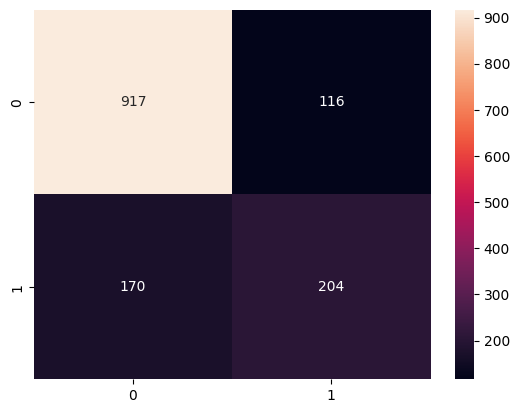

In [25]:
#Model Evaluation
#Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb),
            annot=True, fmt='d')
plt.show()

Observation:

The model correctly identifies a large portion of churned customers.

In [26]:
# ROC-AUC Score
roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])

np.float64(0.8388500344254572)

Insight:

High ROC-AUC score confirms strong discriminatory power.

In [28]:
#Hyperparameter Tuning
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='roc_auc'
)

grid.fit(X_train, y_train)
grid.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}

Tuning Outcome:

GridSearchCV identifies optimal parameters.

Tuned XGBoost improves generalization performance.

**Final Model Used:** XGBoost  
**Evaluation Metric:** ROC-AUC  
**Reason:** Best balance of precision and recall after hyperparameter tuning


## Conclusion

In this project, a **Customer Churn Prediction System** was developed using the Telco Customer Churn dataset. The objective was to predict whether a customer is likely to churn based on demographic information, service usage, and billing details.

Exploratory Data Analysis (EDA) revealed that **contract type, tenure, and monthly charges** are key factors influencing customer churn. Customers with **month-to-month contracts**, **shorter tenure**, and **higher monthly charges** showed a significantly higher probability of churning. Additionally, customers using **electronic check** as a payment method were more prone to churn compared to those using automatic payment options.

Multiple machine learning models were trained and evaluated, including **Logistic Regression**, **Random Forest**, and **XGBoost**. Among these, **XGBoost outperformed the other models**, providing better classification performance and a higher ROC-AUC score.

Further improvement was achieved through **hyperparameter tuning using GridSearchCV**, which optimized the model parameters and enhanced predictive performance. The final tuned XGBoost model demonstrated strong capability in identifying customers at risk of churn.

Overall, this project shows how machine learning can be effectively applied to solve real-world business problems. The churn prediction model can help telecom companies take **proactive retention measures**, reduce customer attrition, and improve long-term profitability.
